<center>

---


# Clase 15
## Árboles de decisión y Random Forest (Bosques Aleatorios)

---
</center>




Vamos a crear un modelo pequeño de bosques aleatorios para predecir una variable categórica.<br>
Para esto vamos a usar una base de datos de viviendas en Boston<br>

# Random Forest

In [52]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
#from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [53]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
datos = pd.read_csv(url)

# Visualizar los primeros registros del DataFrame
datos.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# Datos


El set de datos Boston disponible en la librería scikitlearn contiene precios de viviendas de la ciudad de Boston, así como información socio-económica del barrio en el que se encuentran.

**objetivo:** Ajustar un modelo de regresión que permita predecir el precio medio de una vivienda ```(MEDV)``` en función de las variables disponibles.

Número de instancias(observaciones): 506

Número de atributos: 13 predictivos numéricos/categoriales.



Información de atributos (variables):
- `CRIM`: índice de criminalidad per cápita por ciudad
- `ZN`: proporción de suelo residencial para lotes de más de 25.000 pies cuadrados
- `INDUS`: proporción de acres comerciales no minoristas por ciudad
- `CHAS`: variable ficticia del río Charles (= 1 si la zona linda con el río; 0 en caso contrario)
- `NOX`: concentración de óxidos nítricos (partes por 10 millones)
- `RM`: número medio de habitaciones por vivienda
- `AGE`: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
- `DIS`: distancias ponderadas a cinco centros de empleo de Boston
- `RAD`: índice de accesibilidad a las autopistas radiales
- `TAX`: tasa de impuesto sobre la propiedad por valor total de 10.000 $.
- `PTRATIO`: ratio alumnos-docente por ciudad
- `B`: 1000(Bk - 0,63)^2 donde Bk es la proporción de negros por ciudad
- `LSTAT`: % de estatus inferior de la población
- `MEDV`: Valor medio de las viviendas ocupadas por sus propietarios en miles de dólares
Valores de atributos que faltan: Ninguno


Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learnin

In [54]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [55]:
datos.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


<Axes: xlabel='medv', ylabel='Count'>

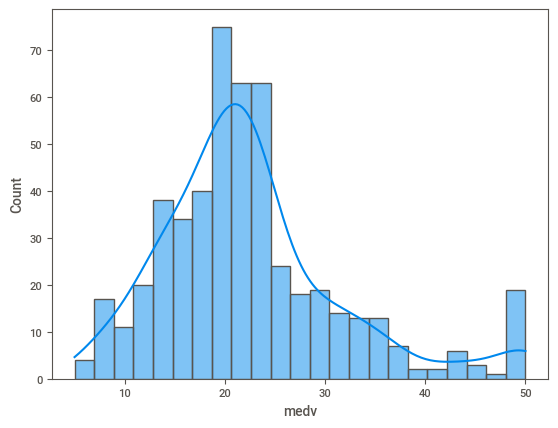

In [56]:
sns.histplot(datos["medv"], kde=True)

<Axes: ylabel='medv'>

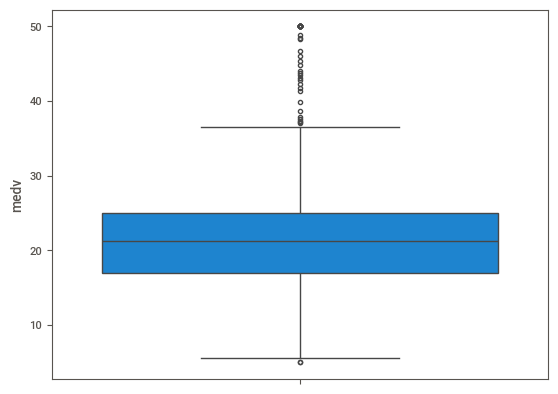

In [57]:
sns.boxplot(y=datos["medv"])

In [58]:
import seaborn as sns

Text(0.5, 1.0, 'Numero de cuartos vs valor medio de la vivienda')

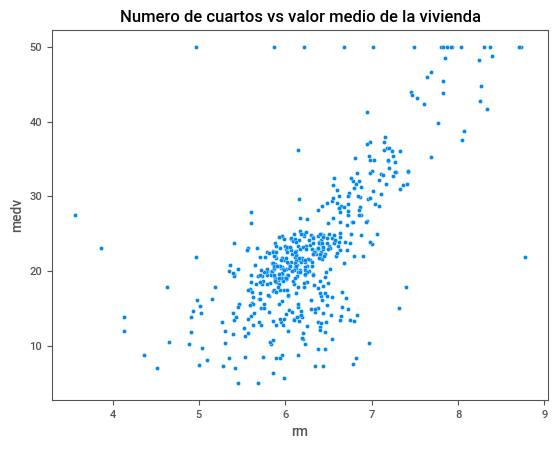

In [59]:
sns.scatterplot(data=datos, x="rm", y="medv")
plt.title("Numero de cuartos vs valor medio de la vivienda")

<Axes: xlabel='crim', ylabel='medv'>

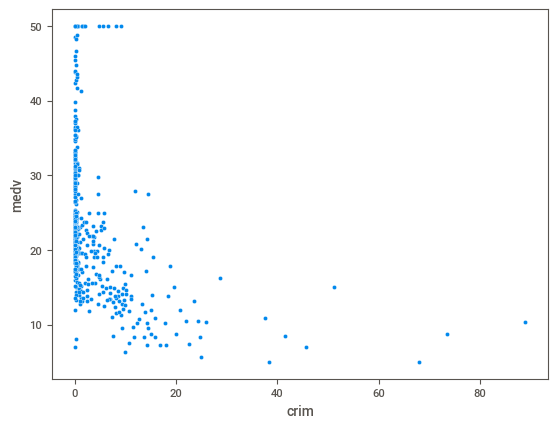

In [60]:
sns.scatterplot(data=datos, x="crim", y="medv")

<Axes: xlabel='b', ylabel='medv'>

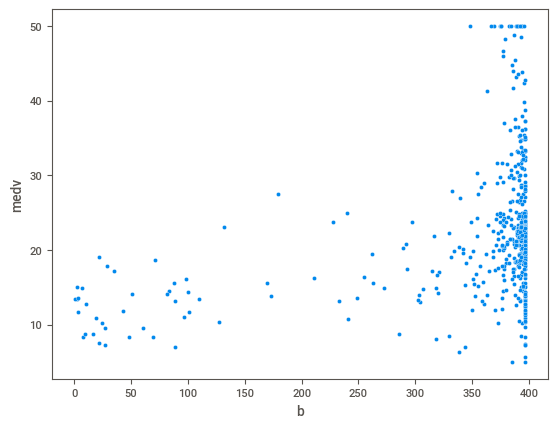

In [61]:
sns.scatterplot(x=datos["b"], y=datos["medv"])

<Axes: >

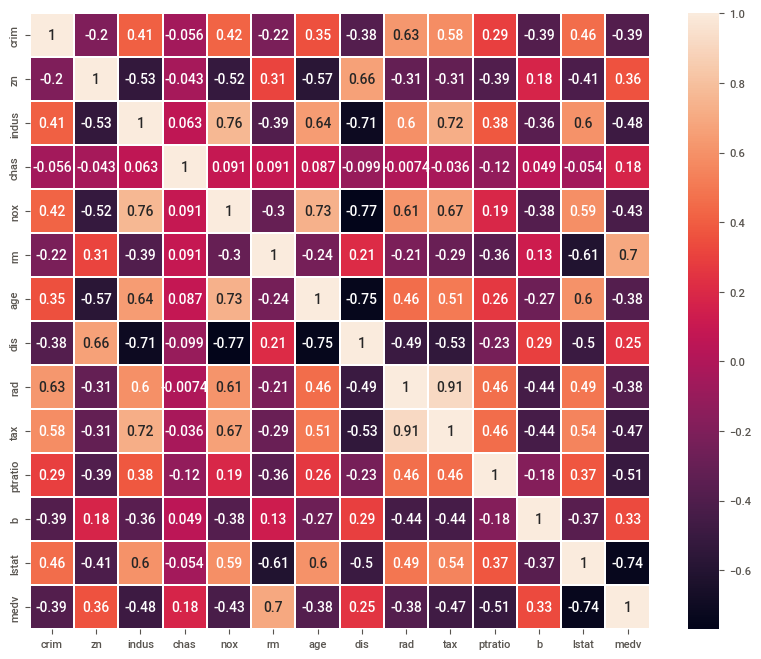

In [62]:
plt.figure(figsize = (10,8))
c=datos.corr()
sns.heatmap(c, annot=True, linewidths=.1)

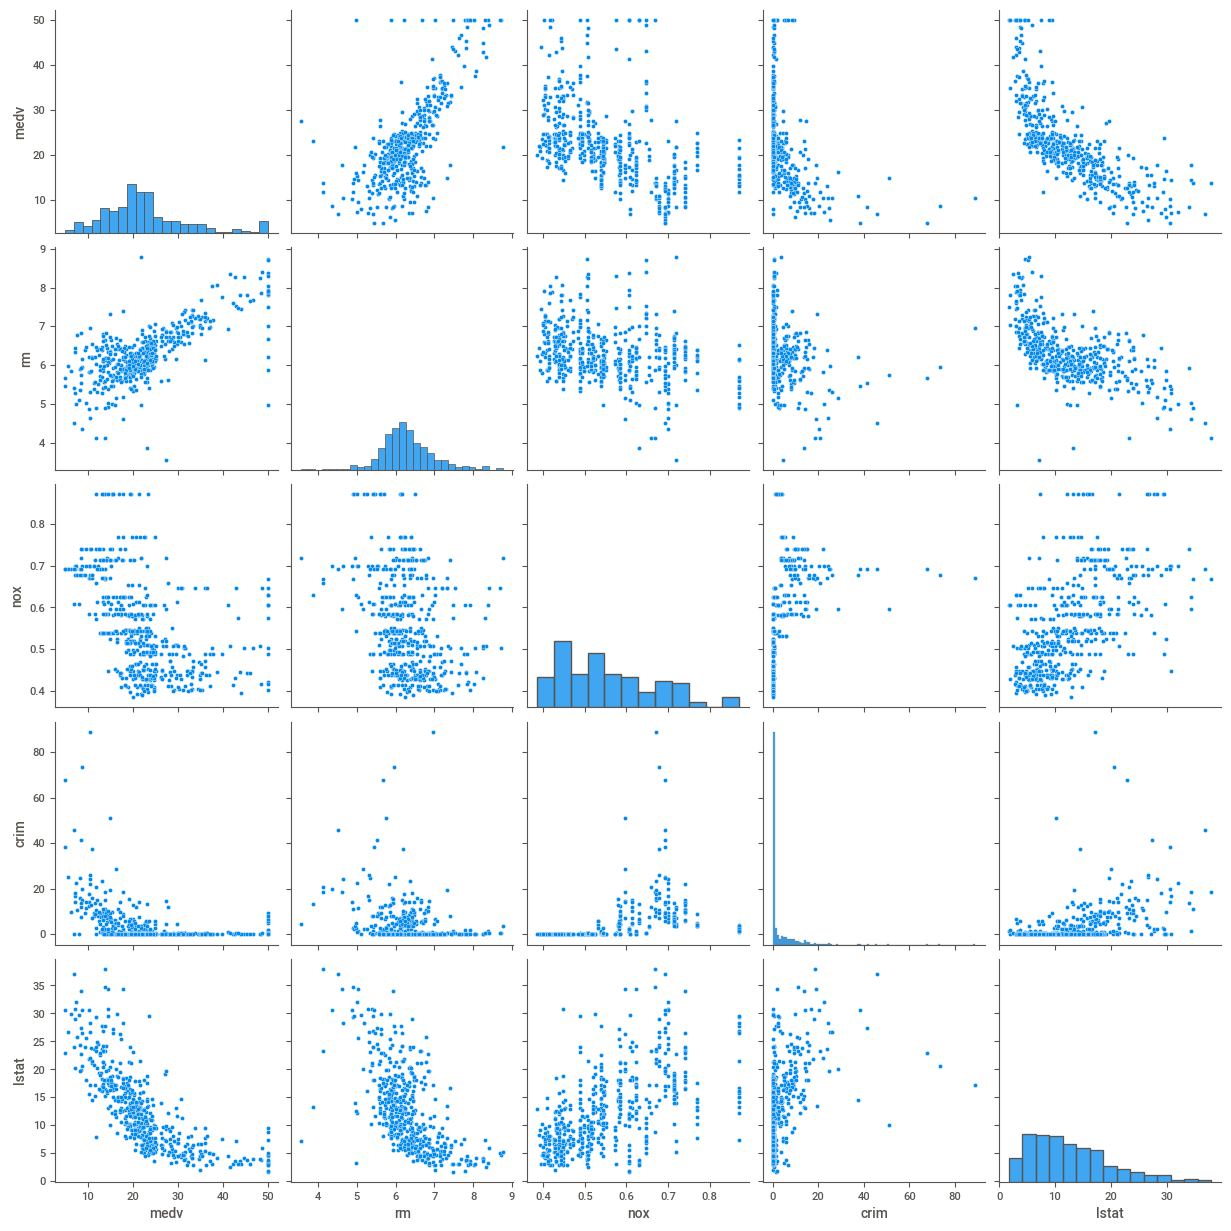

In [63]:
sns.pairplot(datos[["medv", "rm", "nox", "crim", "lstat"]])

### Ajuste del modelo

Se ajusta un modelo empleando como variable respuesta `MEDV` y como predictores todas las otras variables disponibles.

La clase `RandomForestRegressor` del módulo sklearn.ensemble permite entrenar modelos random forest para problemas de regresión. Los parámetros e hiperparámetros empleados por defecto son:

- `n_estimators=100`
- `criterion='mse'`
- `max_depth=None`
- `min_samples_split=2`
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features='auto'
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- bootstrap=True
- oob_score=False
- n_jobs=None
- random_state=None
- verbose=0
- warm_start=False
- ccp_alpha=0.0
- max_samples=None

De entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

- `n_estimators`: número de árboles incluidos en el modelo.

- `max_depth`: profundidad máxima que pueden alcanzar los árboles.

- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- `max_leaf_nodes`: número máximo de nodos terminales que pueden tener los árboles.

- `max_features`: número de predictores considerados a en cada división. Puede ser:

    + Un valor entero
    + Una fracción del total de predictores.
    + “auto”, utiliza todos los predictores.
    + “sqrt”, raiz cuadrada del número total de predictores.
    + “log2”, log2 del número total de predictores.
    + None, utiliza todos los predictores.
    + oob_score: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

- `n_jobs`: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

- `random_state: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.


Como en todo estudio predictivo, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer esta evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

### División de los datos en train y test

In [64]:
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "medv"),
                                        datos['medv'],
                                        random_state = 123
                                    )


In [65]:
X_train.shape
#X_test.shape

(379, 13)

### Creación del modelo

In [66]:
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'friedman_mse',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )



### Entrenamiento del modelo

In [67]:
# ==============================================================================
modelo.fit(X_train, y_train)

c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


RandomForestRegressor(criterion='friedman_mse', max_features='sqrt',
                      n_estimators=10, n_jobs=-1, random_state=123)

### Predicción y evaluación del modelo


Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test

In [68]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3.8226333834481125


c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [69]:
predicciones

array([19.61, 27.65, 45.56, 16.29, 30.97, 34.68, 26.16,  9.22, 19.11,
       27.87, 21.08, 19.97, 14.51, 30.8 , 19.8 , 18.62, 20.38, 40.94,
       18.72, 15.82, 15.04, 24.67, 32.34, 45.47, 35.49, 21.56, 15.52,
       21.59, 21.48, 18.97, 23.84, 34.26, 11.25, 21.9 , 21.97, 33.42,
       24.43, 12.84, 14.23, 47.17, 30.96, 18.18, 19.41, 48.64, 17.05,
       22.41, 20.99, 22.91, 16.48, 21.89, 32.23, 24.67, 20.51, 10.62,
       22.88, 13.97, 14.31, 10.34, 33.45, 11.9 , 18.48, 18.7 , 17.25,
       18.71, 22.18, 23.23, 24.1 , 18.99, 23.98, 30.02, 20.95, 24.93,
       17.13, 26.55, 16.08, 19.25, 12.26, 19.02, 29.14, 15.49, 32.32,
       11.21, 23.37, 21.38, 19.64, 23.52, 15.51, 20.07, 21.3 , 30.43,
       11.96, 35.33, 19.36, 24.89, 35.2 , 29.85, 16.88, 33.1 , 25.35,
       35.75, 21.18, 15.33, 45.01, 13.73, 20.4 , 28.55, 20.63, 15.17,
       20.98, 26.11, 20.66, 20.86, 16.76, 18.32, 14.74, 26.77, 25.85,
       13.39, 19.27, 19.73, 18.47, 37.21, 22.53, 10.33, 15.39, 22.38,
       22.59])

In [70]:
a=y_test.reset_index()

In [71]:
a.columns

Index(['index', 'medv'], dtype='object')

Text(0.5, 0, ' Observaciones')

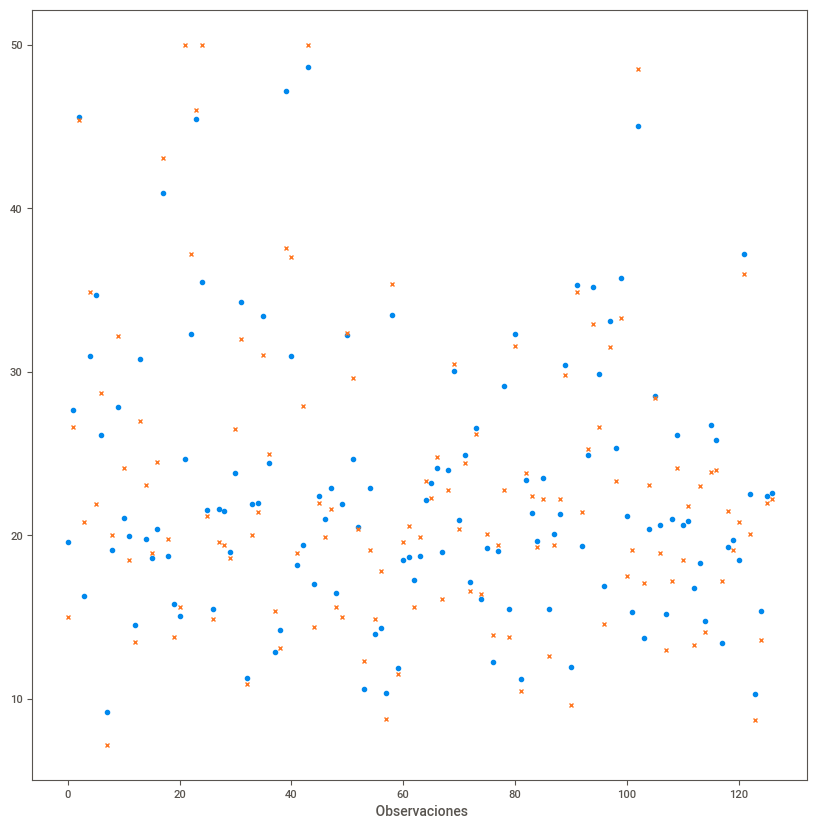

In [72]:
plt.figure(figsize=(10,10))
plt.plot(predicciones, "o")
plt.plot(a["medv"], "x")
plt.xlabel(" Observaciones")

<Axes: xlabel='medv'>

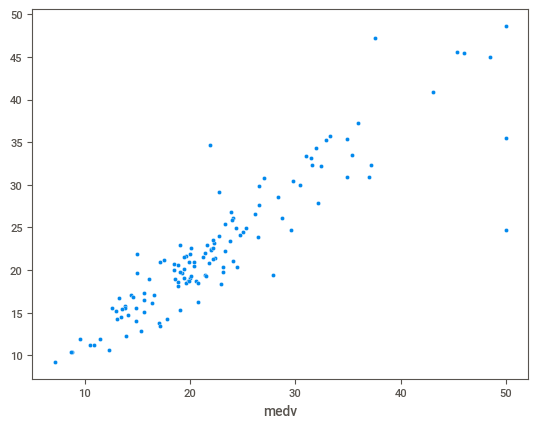

In [73]:
sns.scatterplot(x=a["medv"], y=predicciones )

## Optimización de hiperparámetros


- El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto.

- Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

-Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa.

En la implementación de `RandomForestRegressor`, la métrica devuelta como `oob_score` es el  R2 , si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

## Número de árboles


En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.

c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\sit

Valor óptimo de n_estimators: 141


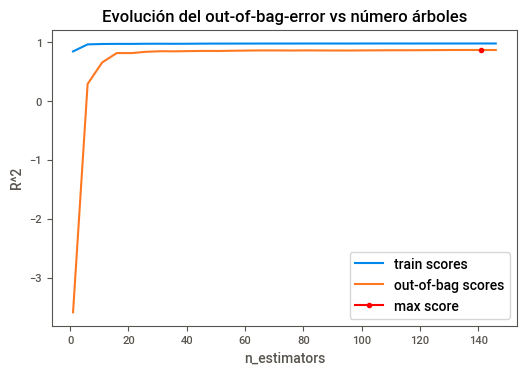

In [74]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'friedman_mse',
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\

Valor óptimo de n_estimators: 26


c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


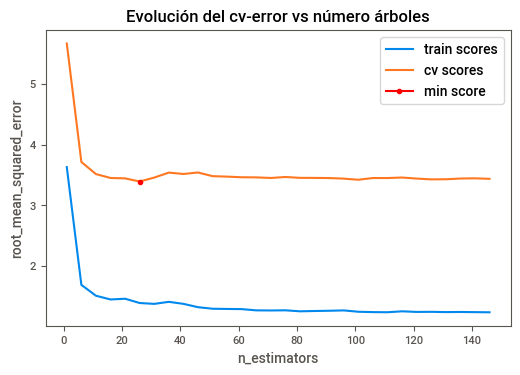

In [75]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'friedman_mse',
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

mbas métricas indican que, a partir de entre 20 y 60 árboles, el error de validación del modelo se estabiliza.

## Max features

El valor de `máx_features` es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: Depr

Valor óptimo de max_features: 5


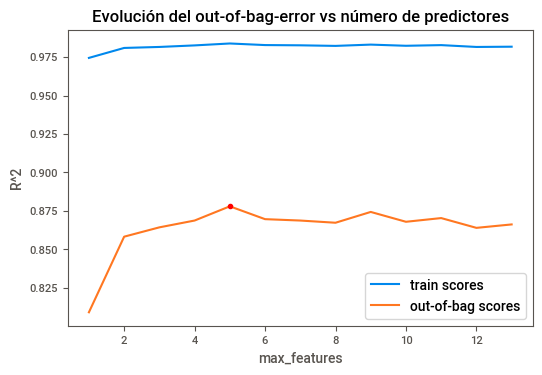

In [76]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'friedman_mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regressi

Valor óptimo de max_features: 7


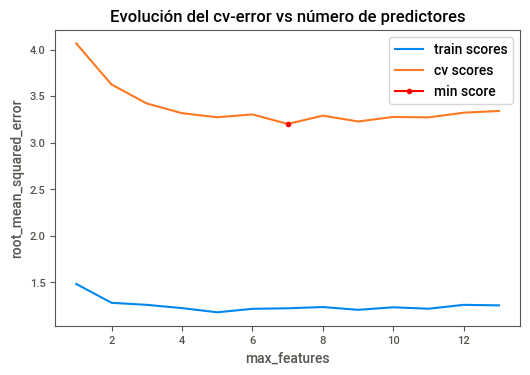

In [77]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:

    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'friedman_mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

### Importancia de predictores


Importancia por pureza de nodos

In [78]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "medv").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\roygo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n


,predictor,importancia
5,rm,0.509496
12,lstat,0.323328
7,dis,0.056804
0,crim,0.030787
4,nox,0.019646
9,tax,0.015742
6,age,0.012247
10,ptratio,0.011733
11,b,0.009252
2,indus,0.005477
